In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),        
    torchvision.transforms.CenterCrop((64, 64)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])




In [3]:
from torchvision import datasets, transforms
train_dataset = datasets.ImageFolder('/kaggle/input/potholehumpvgg/customdataset/train', transform=train_transforms)
test_dataset = datasets.ImageFolder('/kaggle/input/vggtest/vggtest', transform=test_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = test_loader

In [4]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0])


In [5]:
##########################
### MODEL
##########################


class VGG16(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        
        self.block_1 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=64,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_2 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=128,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_3 = torch.nn.Sequential(        
                torch.nn.Conv2d(in_channels=128,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
          
        self.block_4 = torch.nn.Sequential(   
                torch.nn.Conv2d(in_channels=256,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_5 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),    
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))             
        )
            
        height, width = 3, 3 ## you may want to change that depending on the input image size
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512*height*width, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, num_classes),
        )
            
        for m in self.modules():
            if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()
                    
        self.avgpool = torch.nn.AdaptiveAvgPool2d((height, width))
        
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten
        
        logits = self.classifier(x)
        #probas = F.softmax(logits, dim=1)

        return logits                  

In [6]:
BATCH_SIZE = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device =DEVICE

In [7]:
import torch.nn as nn

In [8]:
log_interval = 1
total_steps = len(train_loader)

In [9]:
model = VGG16(num_classes=2)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)
criterion = nn.CrossEntropyLoss()
num_epochs = 100


# Initialize variables to track best accuracy and corresponding model weights
best_accuracy = 0.0
best_model_weights = None

# Training loop
# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate validation accuracy
        accuracy = 100 * correct / total
        
        print('Accuracy of the network on the {} validation images: {:.2f} %'.format(total, accuracy))
        
        # Check if current model is the best so far
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            # Save the current best model weights
            best_model_weights = model.state_dict()

# Save the best model weights to a file
torch.save(best_model_weights, 'best_model.pth')
print('Best model saved with validation accuracy of: {:.2f}%'.format(best_accuracy))



Epoch [1/100], Loss: 1.1786
Accuracy of the network on the 163 validation images: 68.71 %
Epoch [2/100], Loss: 0.0064
Accuracy of the network on the 163 validation images: 87.12 %
Epoch [3/100], Loss: 0.1473
Accuracy of the network on the 163 validation images: 90.80 %
Epoch [4/100], Loss: 0.0242
Accuracy of the network on the 163 validation images: 93.25 %
Epoch [5/100], Loss: 0.0007
Accuracy of the network on the 163 validation images: 92.02 %
Epoch [6/100], Loss: 0.0252
Accuracy of the network on the 163 validation images: 93.87 %
Epoch [7/100], Loss: 0.0005
Accuracy of the network on the 163 validation images: 92.64 %
Epoch [8/100], Loss: 0.0028
Accuracy of the network on the 163 validation images: 91.41 %
Epoch [9/100], Loss: 0.2070
Accuracy of the network on the 163 validation images: 92.02 %
Epoch [10/100], Loss: 0.0000
Accuracy of the network on the 163 validation images: 92.64 %
Epoch [11/100], Loss: 0.0009
Accuracy of the network on the 163 validation images: 93.87 %
Epoch [1

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [11]:
classes = ['hump', 'pothole']

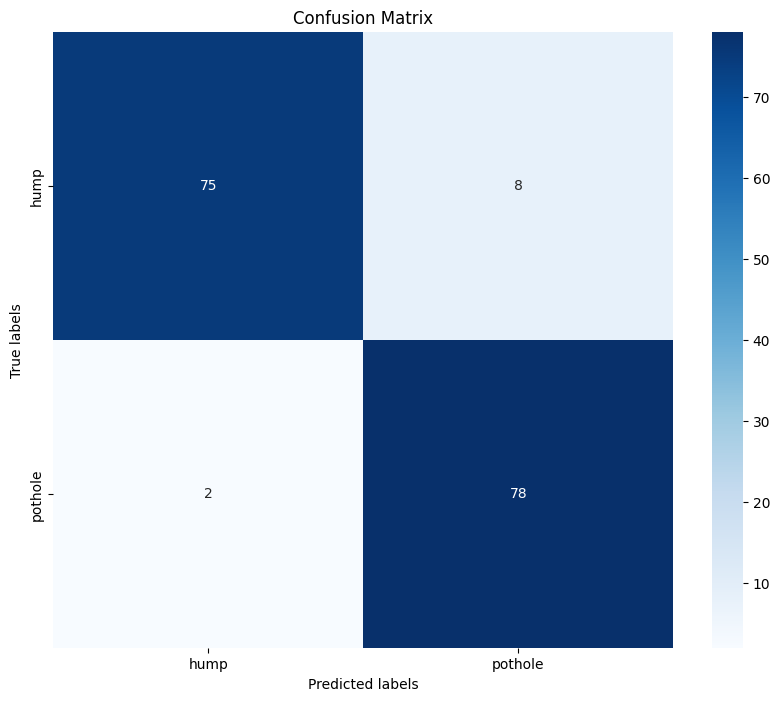

In [12]:
model.eval()  # set the model to evaluation mode

# Prepare test data
# Assuming test_data and test_targets are your test dataset and its corresponding targets

# Perform inference
predictions = []
true_labels = []

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to('cuda'), targets.to('cuda') 
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(targets.tolist())

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.97      0.90      0.94        83
           1       0.91      0.97      0.94        80

    accuracy                           0.94       163
   macro avg       0.94      0.94      0.94       163
weighted avg       0.94      0.94      0.94       163



In [14]:
from PIL import Image

# Load the image
image_path = '/kaggle/input/potholehumpvgg/customdataset/test/pothole/IMG_6071.jpg'  # Replace 'example.jpg' with the path to your image
image = Image.open(image_path)

# Preprocess the image
transform = transforms.Compose([
    torchvision.transforms.Resize((70, 70)),        
    torchvision.transforms.CenterCrop((64, 64)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


input_image = transform(image).unsqueeze(0)  # Add a batch dimension


model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set the model to evaluation mode

# Perform inference
with torch.no_grad():
    input_image = input_image.to('cuda')  # Move the input image to GPU if available
    output = model(input_image)

# Postprocess the output
_, predicted = torch.max(output, 1)
predicted_class = predicted.item()

# Assuming you have a list of class names
  # Replace with your class names
predicted_label = classes[predicted_class]

print('Predicted class:', predicted_label)

Predicted class: pothole
